# Анализ воронки приложения по продаже продуктов питания

В данном проекте будут изучены данные мобильного приложения стартапа по продаже продуктов питания.

**Задачи исследования:** 
1. разобраться, как ведут себя пользователи мобильного приложения. 
2. дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Для проведения A/A/B-эксперимента пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо по результатм A/A/B-эксперимента выяснить, какой шрифт лучше

**Ход исследования**  
1. Изучим воронку продаж.  
    1.1 Узнаем, как пользователи доходят до покупки.   
    1.2 Посчитаем сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах  
    1.3 На каких шагах «застревают» пользователи  
2. Исследуем результаты A/A/B-эксперимента.   
    2.1 Выясним какой шрифт приложения воспринимается пользователями лучше

**Этапы исследования:** 
1. Загрузка данных
2. Подготовка данных к анализу
3. Изучение и проверка данных
4. Изучение воронки событий
5. Изучение результатов эксперимента

## Шаг 1. Загрузка данных 
Импортируем библиотеки, загрузим данные.

In [1]:
#импорт библиотек
import os
import pandas as pd

from matplotlib import pyplot as plt
import scipy.stats as stats
import math as mth

from datetime import datetime, timedelta
import datetime as dt

from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

import re
import warnings
warnings.filterwarnings("ignore") 

In [2]:
data = pd.read_csv('C:/Users/Лиен/Desktop/Jupyter/logs_exp.csv', sep='\t')

## Шаг 2. Подготовка данных к анализу

Проверим:
1. Верно ли названы стоблцы
2. Соответствуют ли типы данных в колонках значениям
3. Есть ли в данных пропуски и дубликаты.

In [7]:
print('Первые строки таблицы:')
display(data.head());
print('-' * 50)
print('Основная информация о таблице:')
print(data.info());
print('-' * 50)
print('Проверка таблицы на пропуски:')
print(data.isna().sum());
print('-' * 50)
print('Проверка таблицы на дубликаты:')
print(data.duplicated().sum());

Первые строки таблицы:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


--------------------------------------------------
Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
--------------------------------------------------
Проверка таблицы на пропуски:
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
--------------------------------------------------
Проверка таблицы на дубликаты:
413


### 2.1 Выполним предобработку
1. Изменим названия столбцов;
2. Пропусков нет, но есть дубликаты. Удалим их
3. Добавим столбец даты и времени и отдельный столбец дат

In [8]:
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id','EventTimestamp':'unix_time','ExpId':'group'})
data = data.drop_duplicates()

In [9]:
data['event_date_time'] = pd.to_datetime(data['unix_time'], unit = 's')
data['event_date'] = pd.to_datetime(data['event_date_time']).dt.date 
display(data.head());
data.info()

,event_name,user_id,unix_time,group,event_date_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   unix_time        243713 non-null  int64         
 3   group            243713 non-null  int64         
 4   event_date_time  243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


**Вывод**: 
На данном этапе было сделано:   
- изменены названия столбцов, 
- удалены дубликаты 
- добавлены 2 столбца с данными о дате и времени событий.

Таким образом, таблица приобрела следующий вид:   
**event_name** — название события;  
**user_id**	 — уникальный идентификатор пользователя;  
**unix_time** — время события в формате unix_time (с точностью до секунды);  
**group** — номер эксперимента, где 246 и 247 — контрольные группы, а 248 — экспериментальная;  
**event_date_time**	- дата и временя события;  
**event_date** - дата события.

Количество строк в таблице - 243713.  

In [11]:
# Проверим, есть ли пользователи, которые попали в несколько групп теста 
group_nunique = data.groupby('user_id').agg({'group':'nunique'}).reset_index()
print('Количество пользователей, попавших в несколько групп:', group_nunique.query('group > 1')['group'].count())

Количество пользователей, попавших в несколько групп: 0


## Шаг 3. Изучение и проверка данных 

    3.1. Рассчитаем количество событий в логе
    3.2. Рассчитаем количество пользователей в логе
    3.3. Рассчитаем среднее количество событий на пользователя
    3.4. Узнаем за какой период имеются данные: 
        3.4.1. Найдем максимальную и минимальную дату. 
        3.4.2. Построим гистограмму по дате и времени. 
        3.4.3. Посмотрим одинаково ли полные данные за весь период (есть ли "перекос" данных)  
        3.4.4. Отсеим неполные данные. 
        3.4.5. Повторно проверим период, за который имеются данные 
    3.5. Посчитаем количество событий и пользователей, которые были отфильтрованы
    3.6. Приверим, что у вас есть пользователи из всех трёх экспериментальных групп.

In [20]:
#3.1 Рассчитаем количество событий в логе
logs = data['event_name'].count()
logs_unique = data.groupby('event_name')['user_id'].unique().count()
print('3.1 Количество событий в логе:', logs)
print('    Количество уникальных событий в логе:', logs_unique)

users = data['user_id'].nunique()
#3.2 Рассчитаем количество пользователей в логе
print('3.2 Количество пользователей в логе:', users)

3.1 Количество событий в логе: 243713
    Количество уникальных событий в логе: 5
3.2 Количество пользователей в логе: 7551


3.3 В количестве событий на пользователя могут быть аномальные значения. Поэтому посмотрим среднее арифмитическое и медиану

In [13]:
#3. Рассчитаем среднее количество событий на пользователя
events_hist = data.groupby('user_id')['event_name'].count().reset_index()
events_hist['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

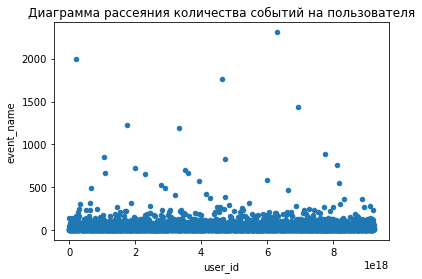

In [14]:
# построим диаграмму рассеяния
events_hist.plot(x='user_id', y='event_name', kind='scatter',title='Диаграмма рассеяния количества событий на пользователя');

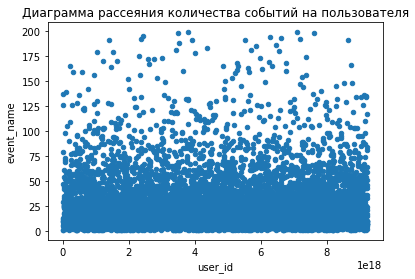

In [15]:
#укрупняем диаграмму
events_hist.query('event_name < 200').plot(
    x='user_id', y='event_name', kind='scatter',title='Диаграмма рассеяния количества событий на пользователя');

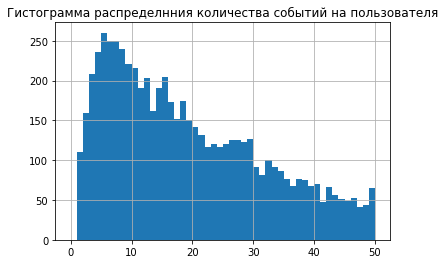

In [16]:
# построим гистограмму
plt.title('Гистограмма распределнния количества событий на пользователя')
events_hist['event_name'].hist(bins=50, range=(0,50));

Среднее арифмитическое количество событий на пользователя - 33, при этом медиана - 20.
По диаграмме рассеяния видим, что есть пользователи, у которых наблюдается от 200 до 2307 событий. 
Эти аномальные значения тянут среднее арифметическое вверх. 

Более детальное рассмотрение диаграммы рассеяния показывает, что у наибольшего числа пользователей менее 50 событий,а гистограмма показывает, что чаще всего на пользователя приходится менее 15 событий. 
Поэтому за среднее количество событий на пользователя принимаем медиану - 20 событий.

### 3.4. Узнаем за какой период имеются данные

In [17]:
data['event_date_time'].head()

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: event_date_time, dtype: datetime64[ns]

In [18]:
print('3.4.1 Данные имеются за период с {} по {}'. format(data['event_date'].min(), data['event_date'].max()))

3.4.1 Данные имеются за период с 2019-07-25 по 2019-08-07


In [ ]:
#3.4.2. Построим гистограмму по дате и времени. 
fig = px.histogram(data, x='event_date_time', title='3.4.2. Гистограмма количества событий по дате и времени')
fig.update_layout(bargap=0.5)
fig.show()

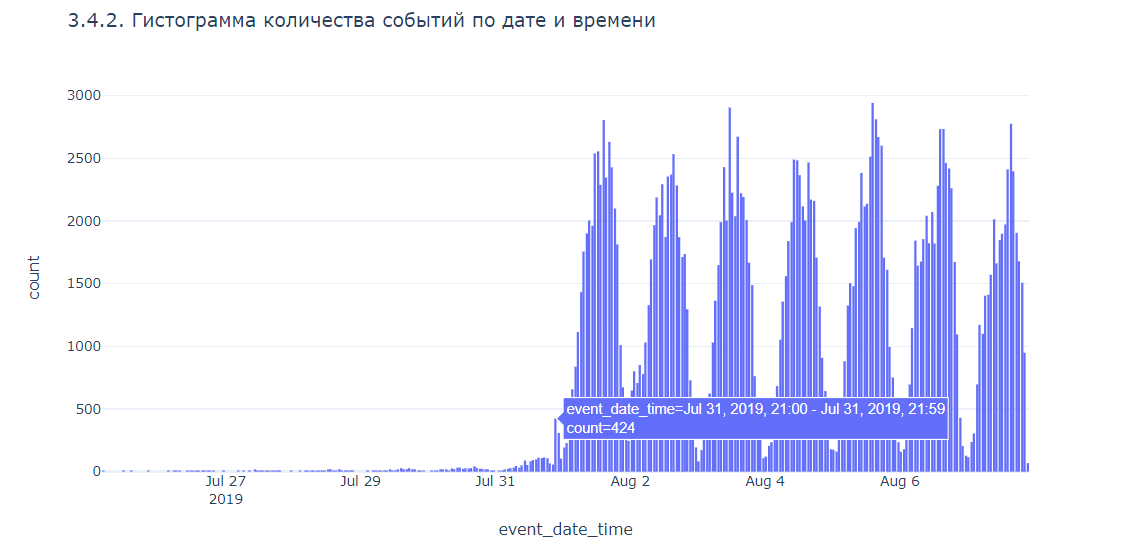

3.4.3. Как мы видим по графику выше, не все данные за рассматриваемый период полные.   
Наблюдаем перекашивание данных с  25 по 31 июля 2019г., причем полные данные появились с 21:00 31 июля (424 события против 56 событий часом ранее). 

Отметим, что с 21:00 31.07.29 можем наблюдать в течение каждого дня характерные периоды повышения активности (в утренние часы) и спада активности (после 15:00). Пик приходится примерно на 12-15 часов.

Отфильтруем дни с неполными данными и посчитаем оставшееся количество событий и пользователей.
Таким образом, мы имеем полные данные за 7 дней. 

In [21]:
#отбросим неполные данные
data_filtered = data.query('event_date_time >= "2019-07-31 21:00:00"')
print('3.4.4 Полные данные имеются за период с {} по {}'. format(data_filtered['event_date_time'].min(), data_filtered['event_date_time'].max()))

3.4.4 Полные данные имеются за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17


In [22]:
#3.4.5 Рассчитаем количество оставшихся событий в логе
logs_filtered = data_filtered['event_name'].count()
print('3.4.5 Количество оставшихся событий в логе:', logs_filtered)
print('Количество отброшенных событий:', logs-logs_filtered)
print('Доля отброшенных событий: {0:.2f}%'.format((1-logs_filtered/logs)*100))
print()
# Рассчитаем количество оставшихся пользователей в логе
users_filtered = data_filtered['user_id'].nunique()
print('Количество оставшихся пользователей в логе:', users_filtered)
print('Количество отброшенных пользователей:', users-users_filtered)
print('Доля отброшенных пользователей: {0:.2f}%'.format((1-users_filtered/users)*100))
print()
# Рассчитаем cреднее количество событий на пользователя
print('Cреднее количество событий на пользователя:', data_filtered.groupby('user_id')['event_name'].count().median())

3.4.5 Количество оставшихся событий в логе: 241724
Количество отброшенных событий: 1989
Доля отброшенных событий: 0.82%

Количество оставшихся пользователей в логе: 7538
Количество отброшенных пользователей: 13
Доля отброшенных пользователей: 0.17%

Cреднее количество событий на пользователя: 19.0


3.4.6. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [23]:
users_in_group = data_filtered.groupby('group').agg({'user_id':'nunique'}).reset_index()
users_in_group

,group,user_id
0,246,2484
1,247,2517
2,248,2537


В каждой экспериментальной группе есть пользователи. На этапе предобработки выяснили, что пользователи в группах не пересекаются.

**Вывод по шагу 3. Изучение и проверка данных**:  

На данном этапе были отсечены неполные данные с 2019-07-25 по 2019-07-31 (до 21:00:57).  
Было отфильтровано малозначимое количество событий (0.82%) и пользователей (0.17%).

После удаления неполных данных стало:
- количество событий в логе - 241 724, 
- количество пользователей в логе - 7 538, 
- среднее количество событий на пользователя - 19

Дальнейший анализ будет сделан по данным с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.  
Пользователи есть из всех трёх экспериментальных групп.

## Шаг 4. Изучение воронки событий

    1. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
    2. Посчитаем, сколько пользователей совершали каждое из этих событий. 
        2.1 Отсортируем события по числу пользователей. 
        2.2 Посчитаем долю пользователей, которые хоть раз совершали событие.
    3. Предположим, в каком порядке происходят события:
        3.1 Все ли события выстраиваются в последовательную цепочку.
        3.2 Какие события можно не учитывать при расчёте воронки.
    4. Посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)
    5. Изучим, на каком шаге теряется больше всего пользователей
    6. Рассчитаем долю пользователей, которые доходят от первого события до оплаты

### 4.1. Какие события есть в логах, как часто они встречаются

,event_name,user_id
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


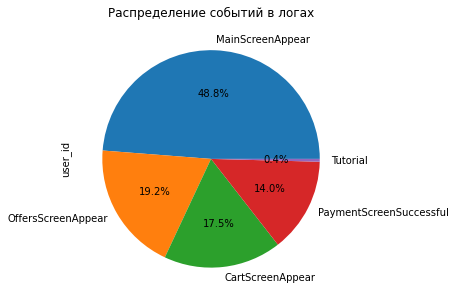

In [24]:
#4.1. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
events = data_filtered.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)
display(events.reset_index())

events.plot(y='user_id', kind='pie', autopct='%0.01f%%', figsize=(5,5), title = "Распределение событий в логах", legend=None);

**Вывод:**  
В логах представлено 5 различных событий: 
1. MainScreenAppear (отображение главного экрана)
2. OffersScreenAppear (отображение экрана предложений)
3. CartScreenAppear (отображение экрана корзины)
4. PaymentScreenSuccessful (экран успешной оплаты) 
5. Tutorial (Руководство)

Чаще всего встречается событие MainScreenAppear - 49% событий  
Реже всего появляется событие Tutorial - 0,4%.   
Редкое появление события Tutorial в данных может говорить о том, что данный шаг необязателен и пропускается пользователями

### 4.2 Посчитаем, сколько пользователей совершали каждое событие. 
    4.2.1 Отсортируем события по числу пользователей. 
    4.2.2 Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
users_events = data_filtered.groupby('event_name', as_index=False).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
users_events['share, %']= round((users_events['user_id'] / users)*100)
users_events.columns=['event_name', 'users_count', 'share, %']
users_events

,event_name,users_count,"share, %"
1,MainScreenAppear,7423,98.0
2,OffersScreenAppear,4597,61.0
0,CartScreenAppear,3736,49.0
3,PaymentScreenSuccessful,3540,47.0
4,Tutorial,843,11.0


По количетву пользователей, события распределены следующим образом:
- отображение главного экрана - у 98% пользователей;
- отображение экрана предложений - у 61% пользователей;
- отображение экрана корзины - у 49,5% пользователей;
- экран успешной оплаты появляется у 47% пользователей;
- и у 11% пользователей появляется Руководство

### 4.3. Предположим, в каком порядке происходят события:

Исходя из количества каждого события и количества пользователей, совершивших эти события, можем предположить следующую последовательность действий пользователей:

1) Отображение главного экрана ->   
2) Отображение экрана предложений ->   
3) Отображение экрана корзины ->   
4) Экран успешной оплаты   

Судя по данным события Tutorial, данный шаг не обязателен и чаще всего пользователи его пропускают.   
По этой причине, исключим шаг из анализа воронки

На главный экран попадают не 100% пользователей. Можем предположить, что пользователи могут попасть на иной экран приложения, минуя главную страницу 

### 4.4. Посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [26]:
# исключение Tutorial из анализа воронки
users_events = users_events.query('event_name != "Tutorial"')

# расчёт доли пользователей, которые перешли на следующий шаг воронки относительно предыдущего шага
users_events['events_funnel,%'] = round((users_events['users_count'].pct_change()+1)*100).fillna(100)
users_events

,event_name,users_count,"share, %","events_funnel,%"
1,MainScreenAppear,7423,98.0,100.0
2,OffersScreenAppear,4597,61.0,62.0
0,CartScreenAppear,3736,49.0,81.0
3,PaymentScreenSuccessful,3540,47.0,95.0


In [ ]:
#визуализация воронки событий относительно числа пользователей на предыдущем шаге
fig = go.Figure(go.Funnel(
    y = users_events['event_name'],
    x = users_events['events_funnel,%'],
    textposition = "inside",
    textinfo = "percent initial"))
fig.update_layout(
        title='Доля пользователей переходящих на следующий шаг воронки относительно прошлого шага')
fig.show()

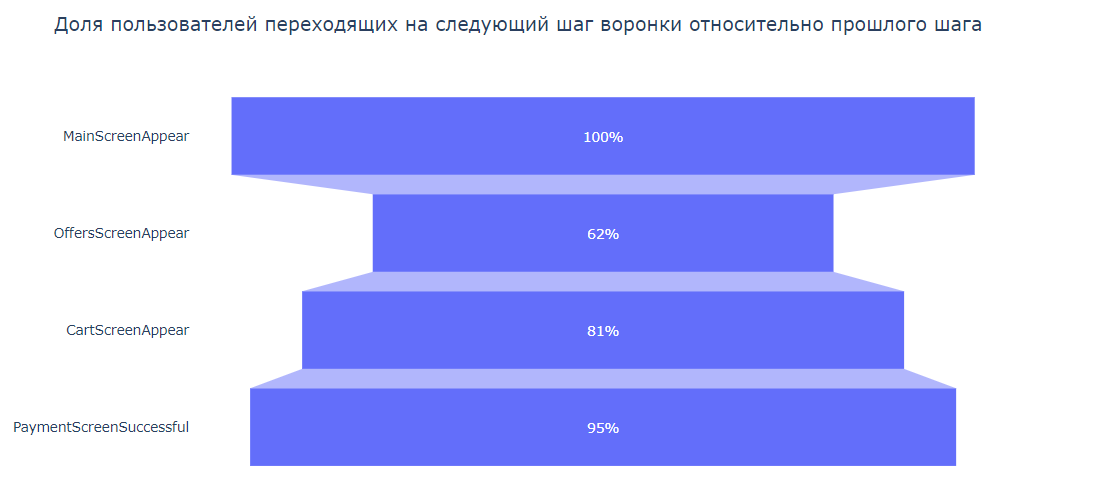

In [28]:
# распределение событий по экспериментальным группам
groups_funnel = data_filtered.query('event_name !="Tutorial"').pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by=246, ascending=False).reset_index()
groups_funnel

group,event_name,246,247,248
0,MainScreenAppear,2450,2479,2494
1,OffersScreenAppear,1542,1524,1531
2,CartScreenAppear,1266,1239,1231
3,PaymentScreenSuccessful,1200,1158,1182


In [29]:
# расчёт доли пользователей, которые перешли на следующий шаг воронки относительно предыдущего шага в разрезе групп
groups_funnel['246_funnel,%'] = round((groups_funnel[246].pct_change()+1)*100)
groups_funnel['247_funnel,%'] = round((groups_funnel[247].pct_change()+1)*100)
groups_funnel['248_funnel,%'] = round((groups_funnel[248].pct_change()+1)*100)
groups_funnel=groups_funnel.fillna(100)
groups_funnel

group,event_name,246,247,248,"246_funnel,%","247_funnel,%","248_funnel,%"
0,MainScreenAppear,2450,2479,2494,100.0,100.0,100.0
1,OffersScreenAppear,1542,1524,1531,63.0,61.0,61.0
2,CartScreenAppear,1266,1239,1231,82.0,81.0,80.0
3,PaymentScreenSuccessful,1200,1158,1182,95.0,93.0,96.0


In [ ]:
#визуализация воронки событий относительно числа пользователей на предыдущем шаге в разрезе групп
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group_246',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel['246_funnel,%'],
    textinfo = "percent initial"))

fig.add_trace(go.Funnel(
    name = 'group_247',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel['247_funnel,%'],
    textposition = "inside",
    textinfo = "percent initial"))

fig.add_trace(go.Funnel(
    name = 'group_248',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel['248_funnel,%'],
    textposition = "inside",
    textinfo = "percent initial"))
fig.update_layout(
        title='Доля пользователей в группах, переходящих на следующий шаг воронки относительно прошлого шага')
fig.show()

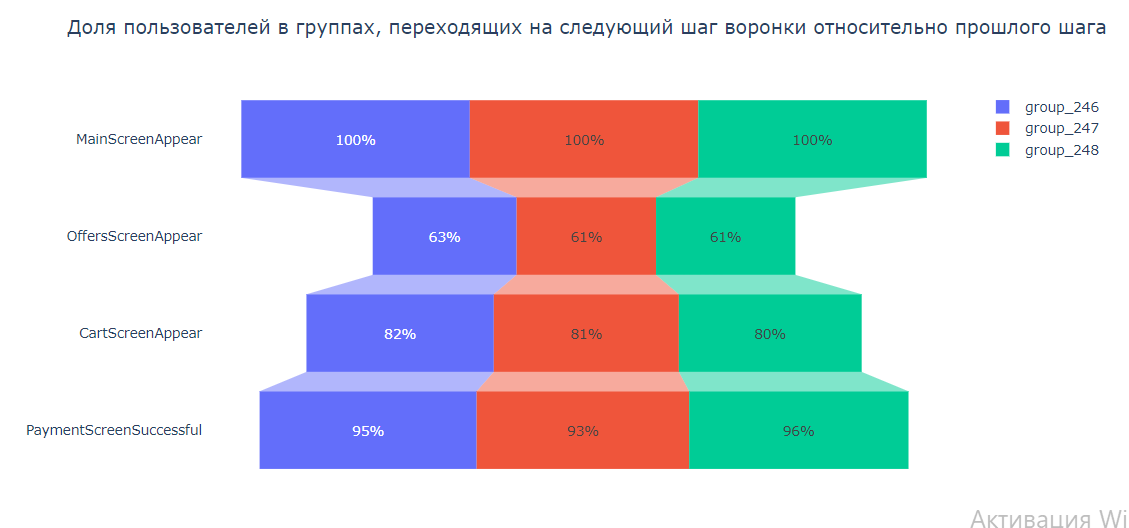

### 4.5. Изучим, на каком шаге теряется больше всего пользователей

По воронке видим, что большая часть пользователей теряются уже после первого шага MainScreenAppear (отображение главного экрана).   

До OffersScreenAppear (отображение экрана предложений) не доходят 38% пользователей. 

Возможно есть факторы, которые отталкивают их от просмотра каталога товаров (долгая загрузка, неудобный интерфейс, баги). С другой стороны, возможно реализована функция добавления товаров в корзину прямо с главного экрана (товары со скидкой, спец. предложения, рекомендации, любимый продукты и тд.), поэтому "просмотр каталога" частью пользователей скипается. В любом случае, вопрос следует рассмотреть более детально, чтобы понять насколько это влияет на финансовые показатели и впечатления пользователей.

Далее доля перешедших пользователей относительного прошлого этапа растёт:
- на третий этап CartScreenAppear перешло 49% от общего числа пользователей, что составляет 82% пользователя шага OffersScreenAppear
- на четвертый этап PaymentScreenSuccessful перешло 47% от общего числа пользователей, что составляет 95% пользователей шага  CartScreenAppear

### 4.6. Рассчитаем долю пользователей, которые доходят от первого события до оплаты

**Построим последовательную воронку в разрезе групп:**

In [ ]:
#визуализация последовательной воронки событий
fig = go.Figure(go.Funnel(
    y = users_events['event_name'],
    x = users_events['users_count'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(
        title='Доля пользователей переходящих на следующий шаг воронки')
fig.show()

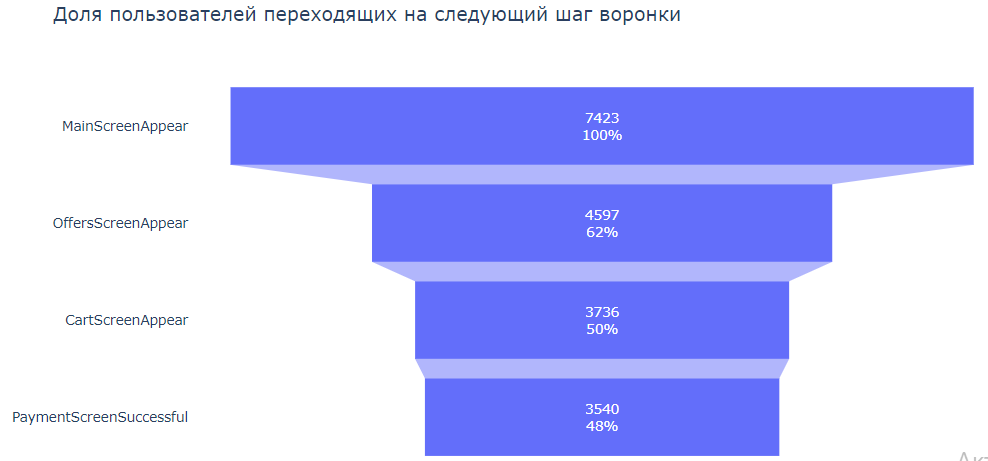

От первого события до оплат дошли 48% пользователей

In [ ]:
# визуализация последовательной воронки в разрезе групп
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group_246',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel[246],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'group_247',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel[247],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'group_248',
    orientation = "h",
    y = groups_funnel['event_name'],
    x = groups_funnel[248],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(
        title='Последовательная воронка событий в разрезе групп')
fig.show()

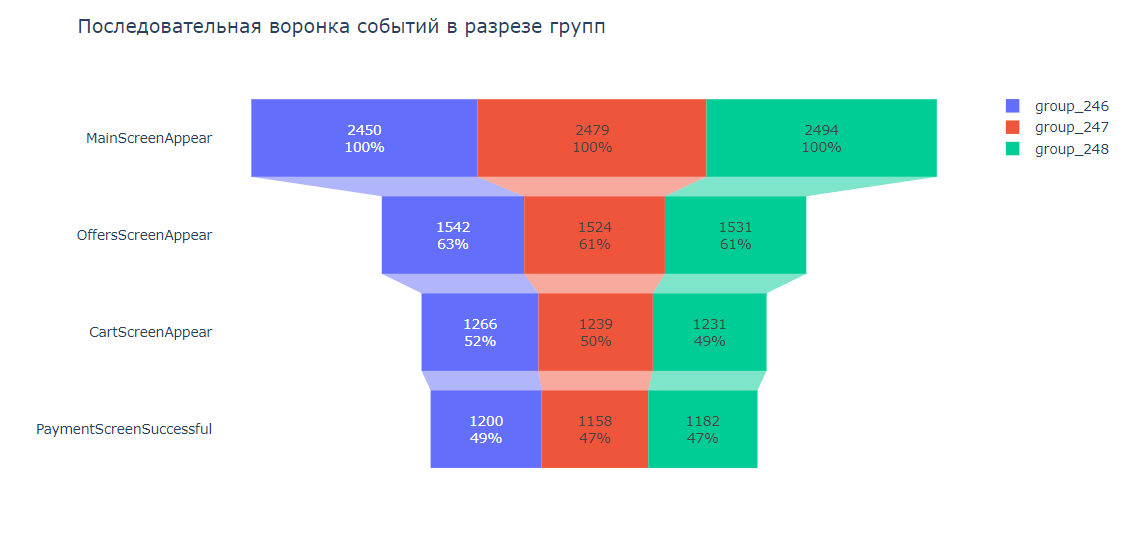

Воронка в разрезе групп не сильно отличается от общей и между самими группами. В группе контрольной группе 246 до оплаты дошло 49% пользователей, в контрольной группе 247 - 47% пользователей, а в экспериментальной группе 248 - 47%

**Вывод**:

В логах представлено 5 различных событий. 4 из них мы включили в воронку. 

Событие Tutorial не является обязательным  для перехода к следующим шагам покупки, большинство пользователей данный шаг пропускает, поэтому далее в анализе воронки данный шаг не учитывался. 

Было сделано предположение, что  события происходят в следующем порядке:
1) Отображение главного экрана (MainScreenAppear)->
2) Отображение экрана предложений (OffersScreenAppear)->
3) Отображение экрана корзины (CartScreenAppear) ->
4) Экран успешной оплаты (PaymentScreenSuccessful)

Больше всего пользователей теряется после первого шага. По какой-то причине 38% пользователей не перешли от главного экрана к каталогу товаров. В дальнейшем компании стоит озадачиться данным вопросом и выяснить почему так происходит. Сокращение потери пользователей на данном этапе может повысить показатели и улучшить пользовательский опыт.

От первого события до оплаты доходят 48% пользователей.

## Шаг 5. Изучение результатов эксперимента

    1. Рассчитаем количество пользователей в каждой экспериментальной группе
    2. Проверим, есть ли между контрольными выборками 246 и 247 А/А-теста разница по статистическим критериям (чтобы проверить корректность всех механизмов и расчётов).
    3. Выберем самое популярное событие
        3.1 Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 
        3.2 Посчитаем долю пользователей, совершивших это событие. 
        3.2 Проверим, будет ли отличие между группами статистически достоверным. 
        3.3 Выводы о корректности работы разбиения на группы 
    4. Выберем самое популярное событие у группы с изменённым шрифтом. 
        4.1 Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
        4.2 Сравним результаты с объединённой контрольной группой. 
        4.3 Выводы из эксперимента
    5. Выберем уровень значимости для проверки статистических гипотез.
        5.1 Посчитаем, сколько проверок статистических гипотез было сделано. 
        5.2 Будут ли различаться выводы при применении другого уровня значимости

### 5.1. Рассчитаем количество пользователей в каждой экспериментальной группе
Количество пользователей в каждой экспериментальной группе мы рассчитывали ранее в п. 3.4.6 и сохранили в переменной users_in_group. Выведем их количество:

In [34]:
users_in_group = data_filtered.groupby('group').agg({'user_id':'nunique'}).T
display(users_in_group)

for i in [246,247,248]:
    print('Количество пользователей в экспериментальной группе {} = {} пользователей'.format(i,users_in_group[i][0]))

group,246,247,248
user_id,2484,2517,2537


Количество пользователей в экспериментальной группе 246 = 2484 пользователей
Количество пользователей в экспериментальной группе 247 = 2517 пользователей
Количество пользователей в экспериментальной группе 248 = 2537 пользователей


### 5.2. Проверим, есть ли между контрольными выборками 246 и 247 А/А-теста разница по статистическим критериям (чтобы проверить корректность всех механизмов и расчётов).


Создание двух групп A вместо одной имеет определённые преимущества:  
- если две контрольные группы равны, точность проведенного тестирования повышается. 
- если же между значениями A и A имеются существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов.   

### 5.3. Выберем самое популярное событие
    5.3.1 Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 
    5.3.2 Посчитаем долю пользователей, совершивших это событие. 
    5.3.3 Проверим, будет ли отличие между группами статистически достоверным. 
    5.3.4 Выводы о корректности работы разбиения на группы 


In [35]:
# 5.3 самое популярное событие
events = events.query('event_name != "Tutorial"').reset_index()
display(events)
print('5.3. Cамое популярное событие - {}. Всего событий событий данной категории - {}'.format(events['event_name'][0],events['user_id'][0]))

,event_name,user_id
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951


5.3. Cамое популярное событие - MainScreenAppear. Всего событий событий данной категории - 117889


In [36]:
#5.3.1 число пользователей, совершивших событие MainScreenAppear в каждой из контрольных групп. 
groups_funnel_5 = data_filtered.query('event_name =="MainScreenAppear"').pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by=246, ascending=False)
display(groups_funnel_5)

for i in [246,247,248]:
    print('5.3.1 Число пользователей группы {}, совершивших событие MainScreenAppear - {} человек'.format(
        i,groups_funnel_5[i][0]))

group,246,247,248
event_name,,,
MainScreenAppear,2450,2479,2494


5.3.1 Число пользователей группы 246, совершивших событие MainScreenAppear - 2450 человек
5.3.1 Число пользователей группы 247, совершивших событие MainScreenAppear - 2479 человек
5.3.1 Число пользователей группы 248, совершивших событие MainScreenAppear - 2494 человек


In [37]:
#5.3.2 Посчитаем долю совершивших событие MainScreenAppear от общего числа группы. 
for i in [246,247,248]:
    print('5.3.2 Доля пользователей группы {}, совершивших событие MainScreenAppear - {}%'.format(
        i,round(groups_funnel_5[i][0]/users_in_group[i][0]*100,2)))

5.3.2 Доля пользователей группы 246, совершивших событие MainScreenAppear - 98.63%
5.3.2 Доля пользователей группы 247, совершивших событие MainScreenAppear - 98.49%
5.3.2 Доля пользователей группы 248, совершивших событие MainScreenAppear - 98.31%


Добавим в датафреймы результаты объединённой контрольной группы '246+247'

In [38]:
# количество пользователей с разбивкой по группам и событиям
groups_funnel['246+247']=groups_funnel[246]+groups_funnel[247]
groups_funnel

group,event_name,246,247,248,"246_funnel,%","247_funnel,%","248_funnel,%",246+247
0,MainScreenAppear,2450,2479,2494,100.0,100.0,100.0,4929
1,OffersScreenAppear,1542,1524,1531,63.0,61.0,61.0,3066
2,CartScreenAppear,1266,1239,1231,82.0,81.0,80.0,2505
3,PaymentScreenSuccessful,1200,1158,1182,95.0,93.0,96.0,2358


In [39]:
# количество пользователей в каждой группе
users_in_group['246+247'] = users_in_group[246]+users_in_group[247]
users_in_group

group,246,247,248,246+247
user_id,2484,2517,2537,5001


**Для дальнейшей проверки гипотез о равенстве групп будем использовать Z-тест.**

**Сформулируем гипотезы**:    
- Нулевая: в сраниваемых группах, между долями пользователей, совершивших событие, разницы нет.   
- Альтернативная: между долями есть значимая разница. 

**Напишем функцию "z_test_func"** 
с 3 параметрами: группа1, группа2, alpha, где:  
- group1  и group2 - сравниваемые группы,  
- alpha - уровень статистической значимости. 

In [40]:
# функция z-теста
def z_test_func(group1, group2, alpha):
    
    for i in groups_funnel.index:
        # пропорция успехов в первой группе:
        p1 = groups_funnel[group1][i] / users_in_group[group1][0] 
        
        # пропорция успехов во второй группе:
        p2 = groups_funnel[group2][i] / users_in_group[group2][0] 
        
        # пропорция успехов в комбинированном датасете:
        p_combined = ((groups_funnel[group1][i] + groups_funnel[group2][i]) / 
                      (users_in_group[group1][0]  + users_in_group[group2][0]))
        
        # разница пропорций в датасетах 
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_in_group[group1][0] + 1/users_in_group[group2][0]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
        distr = stats.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('p-значение события {} : {}'.format(groups_funnel['event_name'][i], p_value))
        if (p_value < alpha):
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        print()

#### 5.3.3 Проверим, будет ли отличие между контрольными группами статистически достоверным. 

**Эксперимент с контрольными группами 246/247**  
Проверим, находят ли статистические критерии разницу между контрольными выборками 246 и 247.

In [41]:
# эксперимент с контрольными группами 246/247
z_test_func(246, 247, 0.01)

p-значение события MainScreenAppear : 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события PaymentScreenSuccessful : 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### 5.3.4 Выводы о корректности работы разбиения на группы 

Размеры контрольных групп немного отличаются. В группе 246 - 2484 пользователей, в группе 247 - 2517 пользователей. 

К критериям успешного A/A-теста относится пункт: количество пользователей в различных группах различается не более, чем на 1%.
В нашем случае, разница в количестве составляет 1,3%. 

Разница в размерах незначительная, к тому же проверка гипотез показала, что между контрольными выборками 246 и 247 статистически значимых различий между долями пользователей нет. То есть обе группы можно считать контрольными.

Тем не менее, для улучшения качества будущих тестов следует доработать механику и/или подход к выделению групп.

### 5.4. Выберем самое популярное событие у группы с изменённым шрифтом. 
    5.4.1 Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
    5.4.2 Сравним результаты с объединённой контрольной группой. 
    5.4.3 Выводы из эксперимента


In [42]:
#5.4 самое популярное событие у группы с изменённым шрифтом (группы 248)
groups_248_funnel = data_filtered.query('group == 248 & event_name != "Tutorial"').pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by=248, ascending=False).reset_index()
display(groups_248_funnel)

print('Cамое популярное событие у группы 248 (с изменённым шрифтомгруппы) -', groups_248_funnel['event_name'][0])

group,event_name,248
0,MainScreenAppear,2494
1,OffersScreenAppear,1531
2,CartScreenAppear,1231
3,PaymentScreenSuccessful,1182


Cамое популярное событие у группы 248 (с изменённым шрифтомгруппы) - MainScreenAppear


#### 5.4.1 Сравним результаты группы с изменённым шрифтом с каждой из контрольных групп в отдельности по каждому событию. 

**Эксперимент с группами 246/248**  
Проверим, находят ли статистические критерии разницу между выборками 246 и 248.

In [43]:
#эксперимент с группами 246/248
z_test_func(246, 248, 0.01)

p-значение события MainScreenAppear : 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события PaymentScreenSuccessful : 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Эксперимент с группами 247/248**  
Проверим, находят ли статистические критерии разницу между выборками 247 и 248.

In [44]:
# эксперимент с группами 247/248
z_test_func(247, 248, 0.01)

p-значение события MainScreenAppear : 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события PaymentScreenSuccessful : 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### 5.4.2 Сравним результаты с объединённой контрольной группой. 

In [45]:
# эксперимент с группами '246+247'/248
z_test_func('246+247', 248, 0.01)

p-значение события MainScreenAppear : 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события PaymentScreenSuccessful : 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### 5.4.3 Выводы из эксперимента

Все тесты показывают, что нет оснований считать доли разными. То есть значимой разницы между группами не наблюдается

### 5.5. Выберем уровень значимости для проверки статистических гипотез.
    5.5.1 Посчитаем, сколько проверок статистических гипотез было сделано. 
    5.5.2 Будут ли различаться выводы при применении другого уровня значимости

#### 5.5.1 Посчитаем, сколько проверок статистических гипотез было сделано.

В пункте 5.4 мы проверили 4 эксперимента с проверкой гипотез о равенстве долей для каждой из 4х событий. 

Таким образом, было сделано 16 проверок статистических гипотез, которые показали, что между группами нет
значимой разницы.

#### 5.5.2 Выбор уровня значимости для проверки статистических гипотез.
*При уровне значимости 0.1 (10%) каждый десятый раз можно получать ложный результат. 
Какой уровень значимости стоит применить? При изменении уровня значимости, необходимо проделать предыдущие пункты и проверить выводы*

- Стандартные значения уровня статистической значимости - 5% и 1%
- Для A/A-теста точность в 1% — распространённый критерий, поскольку группы являются контрольными.

Для проведенных ранее тестов был применен уровень значимости 0.01 (1%), то есть ложный результат возможно получить каждый сотый раз.
Но в связи с тем,что мы делали множественную проверку гипотез, то следует применить метод корректировки уровня значимости, чтобы снизить вероятность ложнопозитивного результата.

По всем прошлым тестам не было оснований отвергать H₀ (нулевую гипотезу), поэтом нам важно обнаружить различия между группами, если они есть, и правильно отклонить нулевую гипотезу, если она не верна. То есть нам нужно повысить мощность теста, сохраняя FWER < ɑlpha. 

Для этого применим Метод Шидака и скорректируем значение уровня значимости  по формуле: 1 - (1 - ɑ)**(1/m)  



In [46]:
#добавим в функцию поправку Шидака

# функция z-теста
def z_test_func(group1, group2, alpha):
    
    #уровень значимости с поправкой Шидака
    shidak_alpha = 1 - (1 - alpha)**(1/16)
    
    for i in groups_funnel.index:
        # пропорция успехов в первой группе:
        p1 = groups_funnel[group1][i] / users_in_group[group1][0] 
        
        # пропорция успехов во второй группе:
        p2 = groups_funnel[group2][i] / users_in_group[group2][0] 
        
        # пропорция успехов в комбинированном датасете:
        p_combined = ((groups_funnel[group1][i] + groups_funnel[group2][i]) / 
                      (users_in_group[group1][0]  + users_in_group[group2][0]))
        
        # разница пропорций в датасетах 
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_in_group[group1][0] + 1/users_in_group[group2][0]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
        distr = stats.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('p-значение события {} : {}'.format(groups_funnel['event_name'][i], p_value))
        if (p_value < shidak_alpha):
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
        print()

In [47]:
# эксперимент с контрольными группами 246/247
print('Эксперимент с контрольными группами 246/247:')
z_test_func(246, 247, 0.01)
print("-"*50)
#эксперимент с группами 246/248
print('Эксперимент с группами 246/248:')
z_test_func(246, 248, 0.01)
print("-"*50)
#эксперимент с группами 247/248
print('Эксперимент с группами 247/248:')
z_test_func(247, 248, 0.01)
print("-"*50)
# эксперимент с группами '246+247'/248
print('Эксперимент с группами "246+247"/248:')
z_test_func('246+247', 248, 0.01)

Эксперимент с контрольными группами 246/247:
p-значение события MainScreenAppear : 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события PaymentScreenSuccessful : 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

--------------------------------------------------
Эксперимент с группами 246/248:
p-значение события MainScreenAppear : 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события OffersScreenAppear : 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение события CartScreenAppear : 0.0

#### 5.5.2 Будут ли различаться выводы при применении другого уровня значимости

Выводы не изменились, значимой разницы между группами не наблюдается

## Общий вывод

Мы изучили записи логов мобильного приложения стартапа по продаже продуктов питания и результаты экспериментов по изменению шрифтов в приложении.   

**1. Изучение и проверка данных**  
Гистограмма событий показала, что в имеются неполные данные на первой неделе наблюдений. Эти данные были исключены из дальнейшего анализа. В итоге остались события с 21:00:57 25 июля по 21:15:17  31 июля 2019г. 
Было отфильтровано малозначимое количество данных — 0,82% событий и 0.17% пользователей.
- количество событий в логе - 241 724,
- количество пользователей в логе - 7 538,
- среднее количество событий на пользователя — 19 (медианное значение, так как в данных имеются выбросы, которые завышают значение средне арифметического) 


**2. Изучение воронки событий**

Событие «Руководство» (Tutorial) встречается в логах меньше всего. То есть большинство пользователей никогда не открывали этот экран. Шаг не является обязательным для перехода к следующим шагам покупки, поэтому его можно не учитывать в воронке.

Было сделано предположение, что события происходят в следующем порядке:

1) Отображение главного экрана (MainScreenAppear) — охватывает больше всего событий и пользователей 98,5%  
2) Отображение экрана предложений (OffersScreenAppear)   
3) Отображение экрана корзины (CartScreenAppear)   
4) Экран успешной оплаты (PaymentScreenSuccessful)

До второго шага воронки не доходят 38% пользователей. В дальнейшем необходимо выяснить почему так происходит и нужны ли изменения. 

Сокращение потери пользователей на данном этапе может повысить результаты и улучшить пользовательский опыт.

От первого события до оплаты доходят 48% пользователей.


**3. Изучение результатов эксперимента**

Мы проверили 16 гипотез с уровнем значимости 0.01. Тесты не выявили значимой разницы между группами 

Так как мы делаем множественную проверку гипотез, то применили поправку Шидака, чтобы снизить вероятность ложнопозитивного результата. 

Выводы по тестам не изменились. Смена шрифтов в приложении не оказывает существенного эффекта, мало влияет на поведение пользователей. 